# Monte Carlo Methods
This notebook recreates the classic card game Blackjack and trains an agent to play effectively using Monte Carlo Methods.

In [243]:
%matplotlib notebook
import random
from copy import deepcopy
import gym
import torch
from collections import namedtuple, defaultdict
import matplotlib.pyplot as pp

In [244]:
env = gym.make('Blackjack-v0')
seed = 1412343214
torch.manual_seed(seed)
env.seed(seed) 
print('Initialized seeds')

Initialized seeds


In [193]:
State = namedtuple('State', ['hand', 'dealer', 'usable_ace'])
StateAction = namedtuple('StateAction', ['s', 'a'])
StateActionReward = namedtuple('StateActionReward', ['s', 'a', 'r'])
Outcome = namedtuple('Outcome', ['state', 'reward', 'is_over', 'empty'])

class BlackJackPolicy:
    def __init__(self):
        # state: [(action, prob), (action, prob)]
        self.p = defaultdict(lambda: [(True, 0.5), (False, 0.5)])
    def action(self, state, greedy=False):
        if greedy:
            return max(self.p[state], key=lambda x: x[1])[0]
        else:
            actions = [a[0] for a in self.p[state]]
            probabilities = [p[1] for p in self.p[state]]
            return random.choices(actions, probabilities)[0] # Weighted action
    
    def get_policy(self):
        #usable_ace_f.append((state, max(actions, key=lambda x: x[1])[0]))
        policy = {}
        for state, actions in self.p.items():
            policy[state] = max(actions, key=lambda x: x[1])[0]
        return policy
            

def episode(policy):
    env.reset()
    finished = False
    state_action_pairs = []
    while not finished:
        state = State(*env._get_obs())
        action = policy.action(state)
        state_action_pairs.append(StateActionReward(state, action, outcome.reward))
        finished = outcome.is_over

    return state_action_pairs

## On Policy First-Visit Monte Carlo Control (for epsilon-soft policies)
Estimates optimal policy by generating episodes from the starting state. 'On Policy' refers to using the same policy to guide actions and generate behavior.

In [204]:
def train(epsilon=0.1, iterations=1000):
    policy = BlackJackPolicy()
    Q = defaultdict(lambda: defaultdict(lambda: (0, 0)))  # state.action.(sum, count) of post rewards
    
    for i in range(int(iterations)):
        if i % 100000 == 0 and i > 0:
            print(f'Progress: {int(i * 100 / iterations)}%', end="\r")

        ep_state_actions = episode(policy)                            # generate an episode
        for i,sar in enumerate(ep_state_actions):                     # iterate state-action-rewards in episode
            s = sar.s
            a = sar.a
            returns = sum(map(lambda x: x.r, ep_state_actions[i:]))   # sum of rewards that follows first occurrence
            Q[s][a] = ((Q[s][a][0] + returns), Q[s][a][1] + 1)        # update Q(s,a) sum of rewards and count

        for s in map(lambda sar: sar.s, ep_state_actions):
            a_star = max(Q[s], key=lambda a: Q[s][a][0] / Q[s][a][1]) # argmax action based on Q average
            p_a = 1 - epsilon + (epsilon / 2)                         # probability of best action
            p_na = epsilon / 2                                        # probability of all other actions (only 1 other)
            policy.p[s] = [(a_star, p_a), (not a_star, p_na)]         # update policy probability of action based on state
    return policy

In [205]:
optimal_policy = train(epsilon=0.15, iterations=1e7)

## Disecting the Results
We now have a trained policy with the structure
```
optimal_policy.p = {
  state_0:  # (hand, dealer, usable_ace)
    [ (action, prob), (action, prob) ],
  state_1:
    [ (action, prob), (action, prob) ],
  . . . ,
  state_n:
    [ (action, prob), (action, prob) ]
}
```
Where states `1-n` represent every possible state in our Blackjack environment.
We can group the states together using `usable_ace, dealer` and find the threshold in our `hand` to see when to hit or stick.

## Displaying Results
No one wants to look at the intelligence of an AI agent in the form of raw text. We want to be able to show grandma or grandpa a visual aid to demonstrate what we have achieved.

This portion prepares the data of our trained policy to be shown using a step line graph. The x and y axis show the sum of the dealer's hand and the agent's hand, respectively. Above the line implies to stay, and on or below to hit.

In [206]:
def get_hit_threshold(state_actions):
    thresholds = {}
    for usable_ace in [True, False]:
        thresholds[usable_ace] = {}
        for i in range(1, 11):
            
            # Consider all states with usable_ace, dealer=i
            hit_threshold = []
            for state,hit in state_actions.items():
                if state.usable_ace == usable_ace and state.dealer == i:
                    hit_threshold.append((state, hit))

            # Filter on hands where (action) hit=True
            hit_states = list(filter(lambda x: x[1], hit_threshold))
            
            # Get the max hand value
            max_threshold_state = max(hit_states, key=lambda x: x[0].hand)
            
            thresholds[usable_ace][i] = max_threshold_state[0].hand
    return thresholds

hit_thresholds = get_hit_threshold(optimal_policy.get_policy())       

In [207]:
print(hit_thresholds)

{True: {1: 18, 2: 17, 3: 17, 4: 17, 5: 17, 6: 17, 7: 17, 8: 17, 9: 18, 10: 18}, False: {1: 16, 2: 12, 3: 11, 4: 11, 5: 11, 6: 11, 7: 16, 8: 16, 9: 16, 10: 15}}


In [250]:
def plot_threshold_data(hit_thresholds, usable_ace):
    x = []
    y = []
    for dealer,threshold in hit_thresholds[usable_ace].items():
        x.append(dealer)
        y.append(threshold)
    # Add extra value for step plot
    x.append(x[-1] + 1)
    y.append(y[-1])
    return (x,y)

plot_data_ace_t = plot_threshold_data(hit_thresholds, usable_ace=True)
plot_data_ace_f = plot_threshold_data(hit_thresholds, usable_ace=False)

print('([Dealer Showing], [When to Hit <=])')
print(plot_data_ace_t)
print(plot_data_ace_f)

([Dealer Showing], [When to Hit <=])
([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [18, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18])
([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [16, 12, 11, 11, 11, 11, 16, 16, 16, 15, 15])


<IPython.core.display.Javascript object>


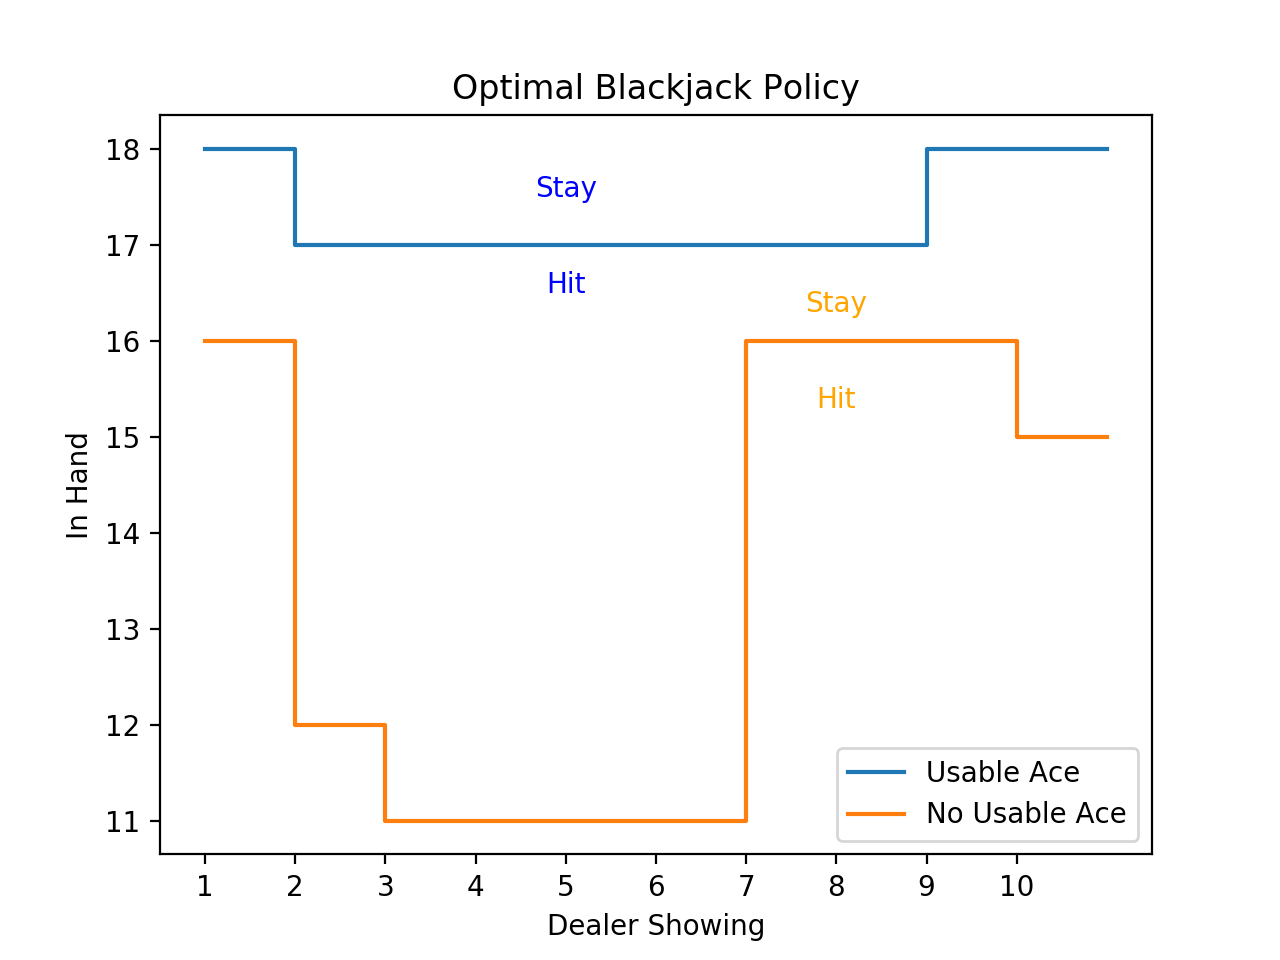

In [247]:
pp.step(plot_data_ace_t[0], plot_data_ace_t[1], where='post', label='Usable Ace')
pp.text(5, 17.5, 'Stay', color='blue', horizontalalignment='center')
pp.text(5, 16.5, 'Hit', color='blue', horizontalalignment='center')

pp.step(plot_data_ace_f[0], plot_data_ace_f[1], where='post', label='No Usable Ace')
pp.text(8, 16.3, 'Stay', color='orange', horizontalalignment='center')
pp.text(8, 15.3, 'Hit', color='orange', horizontalalignment='center')

pp.xlabel('Dealer Showing')
pp.ylabel('In Hand')
pp.xticks(plot_data_ace_f[0][:-1])
pp.legend()
pp.title('Optimal Blackjack Policy')
print('')

In [231]:
def off_policy_prediction(o_policy):
    b_policy = BlackJackPolicy(greedy=False)
    Q = defaultdict(lambda: defaultdict(lambda: (0, 0)))  # state.action.(sum, count) of post rewards
    
    for i in range(10000):
        ep_state_actions = episode(b_policy)
    